# Time Series Forecast using DNN model
Let's predict stock of 10ft empty container of Busan Harbor.   
Trained on 2018~2019 data and tested on 2020 Jan ~ 2020 May data.

# Data Pre-Processing

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [196]:
data = pd.read_csv('../input/monthly-container-holding-of-ports-in-south-korea/container.csv', index_col=0)
data.head()

,Harbor,Date,isKorean,Full_10,Empty_10,Full_20,Empty_20,Full_40,Empty_40,Full_other,Empty_other,R/T
0,Busan,2018-01-01,True,165,273,61282,15753,59612,13995,147,67,3862353
1,Busan,2018-01-01,False,161,133,338680,74981,441504,83605,2879,705,26086071
2,Busan,2018-02-01,True,131,180,58404,14942,55317,12530,89,18,3507757
3,Busan,2018-02-01,False,197,130,329184,71048,440318,84009,3022,913,26385908
4,Busan,2018-03-01,True,90,176,62388,14732,59900,13404,94,116,3782328


In [197]:
data = data[data['Harbor']=='Busan']
data = data[data['isKorean'] == True]
data = data.drop('isKorean', axis=1)
data = data.drop('Harbor', axis=1)

In [198]:
x_data = data[data['Date']<'2019-12-31']
x_data = x_data.drop('Date', axis=1)
x_data.tail()

,Full_10,Empty_10,Full_20,Empty_20,Full_40,Empty_40,Full_other,Empty_other,R/T
38,122,141,56746,13811,54968,12634,107,129,4626833
40,103,129,56114,14313,54180,11148,118,36,3753716
42,126,209,59355,14882,59149,10923,89,74,3925239
44,123,208,63423,15681,63578,12762,143,86,4308047
46,145,220,61909,15782,63221,13515,108,61,4813734


In [199]:
y_data = data[data['Date']<'2020-01-31']
y_data = y_data.drop('Date', axis=1)
y_data = y_data['Empty_10']
y_data = y_data.iloc[1:]
y_data.head()

2     180
4     176
6     204
8     182
10    157
Name: Empty_10, dtype: int64

In [200]:
x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

(24, 9)
(24,)


In [201]:
x_train = x_data[:23]
y_train = y_data[:23]
x_test = x_data[23]
y_test = y_data[23]

# Linear Regression Model

In [202]:
! pip install adamp
from adamp import AdamP
import torch
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

In [203]:
device = 'cuda'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [204]:
Scaler=preprocessing.StandardScaler()
x_train = Scaler.fit_transform(x_train)
x_test = Scaler.transform(x_test.reshape(1, 9))

In [205]:
x_train=np.array(x_train)
y_train=np.array(y_train)
y_test=np.array(y_test)
x_train=torch.FloatTensor(x_train).to(device)
y_train=torch.FloatTensor(y_train).to(device)
x_test=torch.FloatTensor(x_test).to(device)

In [206]:
lin = torch.nn.Linear(9,1)
torch.nn.init.xavier_uniform_(lin.weight)
model = torch.nn.Sequential(lin).to(device)
loss = torch.nn.MSELoss().to(device)
optimizer = AdamP(model.parameters(), lr=1)

In [207]:
epochs = 330
err_history = []
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    hypothesis = model(x_train)
    cost = loss(hypothesis, y_train)
    cost.backward()
    err_history.append(cost.item())
    optimizer.step()
    
    if epoch % 100 == 0 or epoch == 1 or epoch == epochs:
        print('Epoch:', '%04d' % (epoch), 'cost =', '{:.9f}'.format(np.sqrt(cost.item())))

Epoch: 0001 cost = 178.848110095


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0100 cost = 96.669499779
Epoch: 0200 cost = 55.421496157
Epoch: 0300 cost = 46.214780192
Epoch: 0330 cost = 45.731769869


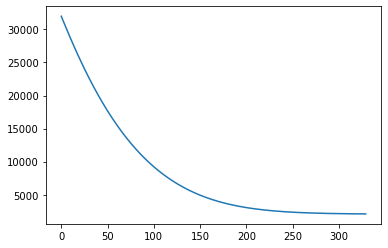

In [208]:
import matplotlib.pyplot as plt

plt.plot(np.array(err_history))
plt.show()

# Test

In [209]:
with torch.no_grad():
    pred = model(x_test)

In [213]:
print('prediction:',pred)
print('error:', np.abs(y_test-pred.item()))

prediction: tensor([[167.4548]], device='cuda:0')
30.545150756835938
